In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from imblearn.over_sampling import SMOTE
0.
import warnings
warnings.filterwarnings('ignore')

In [77]:
data=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')
data.sample(10)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
14042,22,Private,412316,HS-grad,9,Never-married,Sales,Other-relative,Black,Male,0,0,40,?,<=50K
12067,18,?,137363,Some-college,10,Never-married,?,Own-child,White,Female,0,0,4,United-States,<=50K
20171,63,Private,84737,7th-8th,4,Married-civ-spouse,Other-service,Husband,Asian-Pac-Islander,Male,0,0,40,South,<=50K
26832,62,Local-gov,208266,Assoc-voc,11,Divorced,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
30133,43,Self-emp-not-inc,144928,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,60,United-States,<=50K
6757,47,Self-emp-not-inc,121124,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K
13056,43,Private,186396,9th,5,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,20,United-States,<=50K
9098,21,Private,109952,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,50,United-States,<=50K
27304,34,Self-emp-not-inc,114185,Bachelors,13,Divorced,Transport-moving,Not-in-family,White,Male,0,0,50,?,<=50K
9598,43,Local-gov,209899,Masters,14,Never-married,Tech-support,Not-in-family,Black,Female,8614,0,47,United-States,>50K


In [78]:
data.shape

(32560, 15)

In [79]:
data.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


There are 32,560 records in the data set and 15 columns. Fortunately, there are no null/NaN values in any row or column; instead, there are several "?" entries, which I assume were filled in for null/NaN values by the compilers of the data set. Given the categorical nature of the features which contain "?" entries, I do not anticipate that their presence will affect my model building.
The columns age, fnlwgt, education.num, capital.gain, capital.loss and hours.per.week are quantitative variables. In principle they are continuous quantitative variables, although in this data set they all seem to be rounded to the nearest integer. The columns education, marital.status, occupation, relationship, race, sex, native.country, and income are all categorical variables. Since sex almost certainly refers to biological sex rather than gender, it is a binary categorical variable. Whether the remaining columns contain nominal categorical data, ordinal categorical data, or binary categorical data remains to be see

In [81]:
data['Income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [82]:
data.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [83]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [84]:
numerics = ['int8','int16','int32','int64','float16','float32','float64']
categorical_columns = []
features=data.columns.values.tolist()

for col in features:
    if data[col].dtypes in numerics:
        continue
    data[col] = LabelEncoder().fit_transform(data[col])

data

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
1,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
2,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
3,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
4,37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
32556,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
32557,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
32558,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0


In [85]:
#Checking and removing if there is any Duplicate entry present in our dataset
data.drop_duplicates(inplace=True)
data.shape

(32536, 15)

24 Duplicate recods deleted

<h3> <center> Exploratory Data Analysis </center> </h3>
when I downloaded the data set, it is necessary to conduct exploratory data analysis to better understand the nature of the columns (beyond what data type they contain). I should note that I would be doing exploratory data analysis even if there had been column descriptions provided, as exploratory data analysis is vital to uncovering which features seem to be associated with income. It is just even more important that I do so given the specific circumstances at hand.

Looking at the Income Column 

Given that the column "income" is of the object data type -- and that first two income records were "<=50K" -- it is clear that this column does not contain quantitative data. Instead, it contains categorical data. Below, I investigate how many categories comprise this categorical variable, and what percentage of the data falls into each category

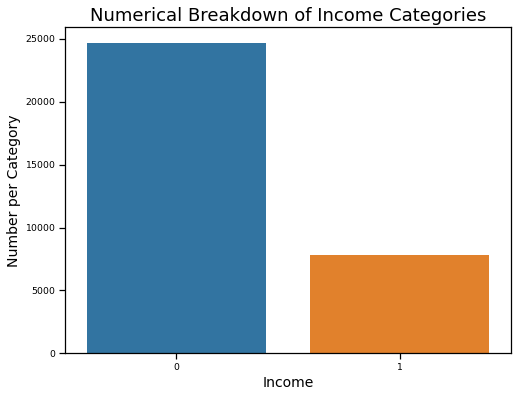

In [86]:
# Plot a bar plot of the number of records which fall into each income category:
plt.figure(figsize = (8,6))
# Set "context" of notebook to control the font size of tick labels:
sns.set_context("notebook", font_scale=0.85, rc={"lines.linewidth": 1.5})
# Use Seaborn's .countplot() to construct the bar plot:
income = sns.countplot(data = data, x = 'Income')
# Make the axis labels more prominant:
plt.xlabel('Income', fontsize=14)
plt.ylabel("Number per Category", fontsize=14)
# Give the graph a prominant title:
plt.title("Numerical Breakdown of Income Categories", fontsize=18)
# Print the graph to file:
plt.savefig('income_bar_graph.png')

"Income" is in fact a binary categorical variable, which opens up many possible supervised machine learning models aimed at predicting it. I was quite happy upon discovering the binary categorical nature of "income."
I also investigated the percentage of records which fall into each "income" category, as shown below.

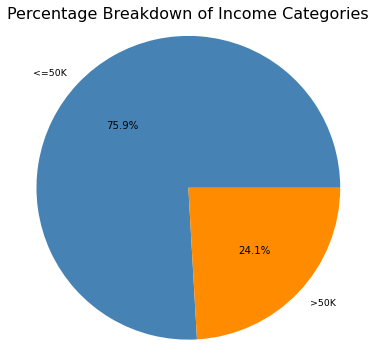

In [87]:
# Find the percentage breakdown of records in each income category:
income_pctgs = data.Income.value_counts()/len(data)

# Construct a pie plot illustrating the percentage breakdown of records in each income category:
plt.figure(figsize=(6,6))
plt.pie(income_pctgs,autopct = '%1.1f%%', labels = ['<=50K','>50K'], colors = ['steelblue','darkorange'])
plt.axis('equal')
plt.title("Percentage Breakdown of Income Categories", fontsize = 16)
plt.savefig('income_pie_chart.png')

Roughly three-quarters of the people in the data set have an income less than or equal to $50,000 per year. This will be important to bear in mind when splitting the data into training and validation sets for training my supervised machine learning models: the breakdown of incomes in each category in the training and validation sets should mirror the overall breakdown.

Looking at the Possible Association Between Hours Worked per Week and Income ¶

Having determined that "income" is a binary categorical variable, and that about one-quarter of people in the data set have an income of more than $50,000 per year, I needed to determine which (if any) features seem to be associated with income. I first looked at "hours.per.week," which I assume is the number of hours per week that people self-reported to the census that they work. "Hours.per.week" is a quantitative variable, so to determine whether or not it is associated with income I looked at the degree of overlap between histograms of hours.per.week split by income.
First, though, I plotted a histogram of hours.per.week for all records in the data set:

Text(0.5, 1.0, 'Self-Reported Hours per Week Worked, All Records')

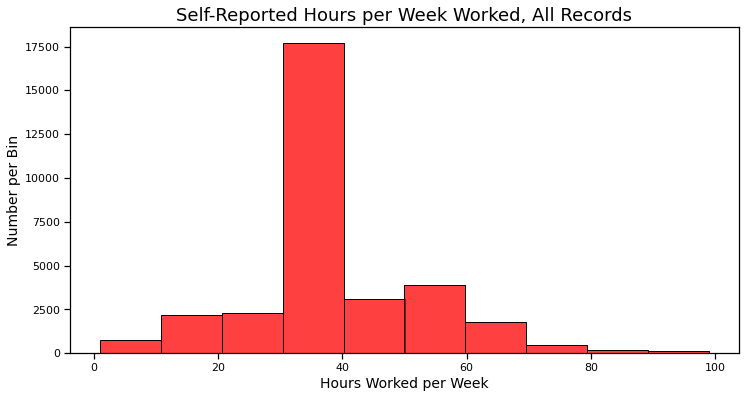

In [88]:
plt.figure(figsize=(12,6))
# Set "context" of notebook to control the font size of tick labels:
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.5})
# Plot the histogram, manually setting the number of bins and not plotting the KDE:
hpwall = sns.histplot(data=data, x = 'Hours_per_week', stat = 'count', color = 'red', bins = 10, kde = False)
# Make the axis labels more prominant:
plt.xlabel('Hours Worked per Week', fontsize=14)
plt.ylabel("Number per Bin", fontsize=14)
# Give the figure a prominant title:
plt.title("Self-Reported Hours per Week Worked, All Records", fontsize=18)

It is clear from the above figure that, by far and away, most people self-reported working between 30 and 40 hours per week. Given that, traditionally, full-time working hours in the U.S. are 40 hours per week, this finding does not surprise me at all. It is also unsurprising that few people worked more than 80 hours per week, and few worked less than 10 hours per week.
Having plotted the distribution of hours worked per week for all data in the data set, I then plotted histograms of self-reported hours per week worked split by income. The result is shown below.

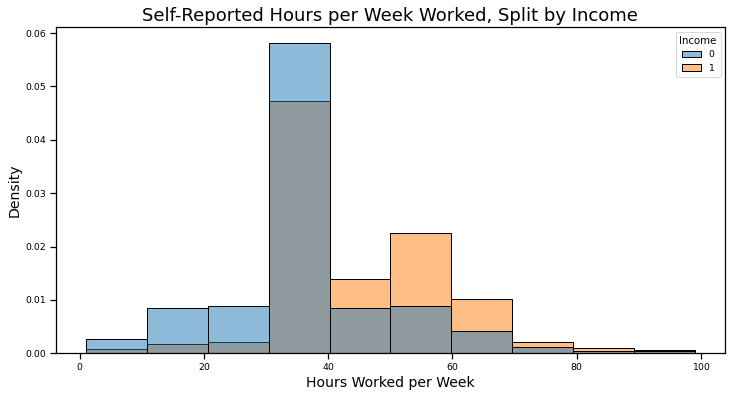

In [89]:
plt.figure(figsize=(12,6))
# Set "context" of notebook to control the font size of tick labels:
sns.set_context("notebook", font_scale=0.85, rc={"lines.linewidth": 1.5})
# Plot the histogram as a density, manually setting the number of bins and not plotting the KDE:
hpwsplit = sns.histplot(data=data, x = 'Hours_per_week', hue = 'Income', stat = 'density', \
                        common_norm = False, bins = 10, kde = False, legend = True)
# Make the axis labels more prominant:
plt.xlabel('Hours Worked per Week', fontsize=14)
plt.ylabel("Density", fontsize=14)
# Give the figure a prominant title:
plt.title("Self-Reported Hours per Week Worked, Split by Income", fontsize=18)
# Print the graph to file:
plt.savefig('hours_per_week_bar_chart.png')

The "density" option normalizes each histogram independently (when keyword "common_norm" is set to false) such that the area under each histogram is 1.
It is clear that there is some overlap between the histograms, but that more people with higher incomes reported working more hours per week. In other words, while both distributions peak at the 30-40 hours per week bin, the higher income distribution has an additional secondary peak between 50 and 60 hours per week that the lower income distribution lacks. Also worth noting is that more people with lower incomes self-reported working fewer hours per week. The differences between the histograms point to hours worked per week and income being associated.

I explored the latter point a bit further by performing a Two-Sample Kolmogorov-Smirnov (K-S) test on the two distributions plotted above. This hypothesis test was chosen because the data are clearly not normally distributed, and a two-sample K-S test is non-parametric and does not require the sample sizes to be identical. (A very good explanation of what precisely a two-sample K-S test is, as well as how to implement one with Microsoft Excel, can be found here.) The null hypothesis in this case is that both measured distributions of hours worked per week are in fact drawn from the same distribution; the alternate hypothesis is that both measured distributions are not drawn from the same distribution. I choose as my significance threshold a value of 0.001 to be extremely conservative.

Looking at Possible Association Between Sex and Income 

I next looked at whether or not sex (biological sex) seems to be associated with income. First, I wanted to see what the percentage breakdown of records by sex was. I do this below.

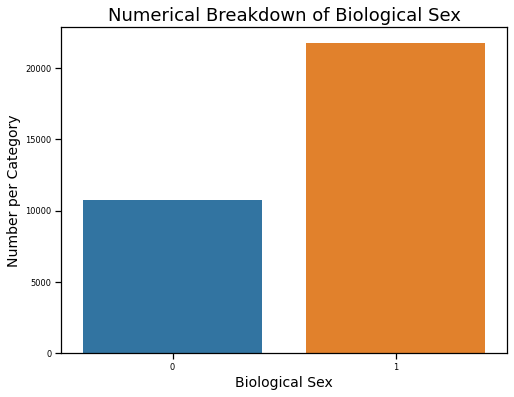

In [90]:
plt.figure(figsize=(8,6))
# Set "context" of notebook to control the font size of tick labels:
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 1.5})
sns.countplot(data = data, x = 'Sex')
# Make the axis labels more prominant:
plt.xlabel('Biological Sex', fontsize=14)
plt.ylabel("Number per Category", fontsize=14)
# Give the figure a prominant title:
plt.title("Numerical Breakdown of Biological Sex", fontsize=18)
# Print the graph to file:
plt.savefig('sex_bar_graph.png')

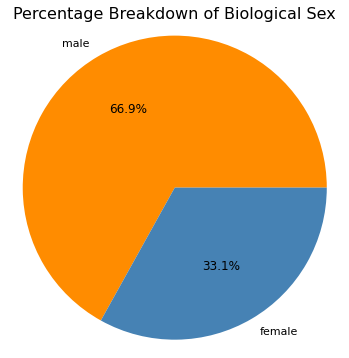

In [91]:
# Find the percentage breakdown of records by sex:
sex_pctgs = data.Sex.value_counts()/len(data)

# Construct a pie plot illustrating the percentage breakdown of records by sex:
plt.figure(figsize=(6,6))
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.5})
plt.pie(sex_pctgs,autopct = '%1.1f%%', labels = ['male','female'], colors = ['darkorange','steelblue'])
plt.axis('equal')
plt.title("Percentage Breakdown of Biological Sex", fontsize = 16)
# Print the graph to file:
plt.savefig('sex_pie_chart.png')

About 2/3 of the records are male and about 1/3 are female. This was important to know because I wanted to make a bar plot of the number of males and females in each income category; since there are so many more males than females, the raw counts of males in each income category would of course be greater because there are more males overall. Instead, I needed to make a bar plot of the percentage of males/females in each income category in order to show a fairer comparison. I do this below.
But first, I illustrate the above point: given the larger number of males overall, there are more males in each income category than there are females. This complicates a visual comparison of the number of each sex split by income.

Text(0.5, 1.0, 'A Bad Bar Plot of Sex Split by Income')

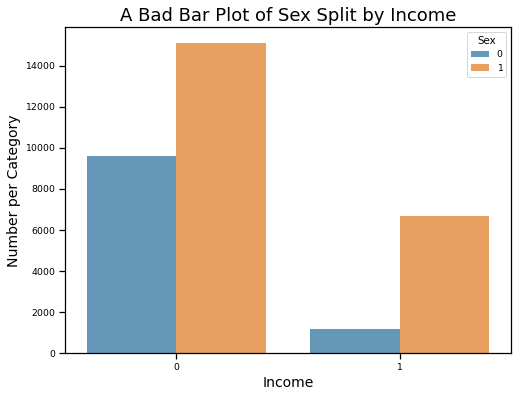

In [92]:
# Construct a bar plot illustrating the percentage breakdown of records in each income category:
plt.figure(figsize=(8,6))
# Set "context" of notebook to control the font size of tick labels:
sns.set_context("notebook", font_scale=0.85, rc={"lines.linewidth": 1.5})
# plot a bar chart of counts per category:
sns.countplot(data = data, x = 'Income', hue = 'Sex', alpha = 0.75)
# Make the axis labels more prominant:
plt.xlabel('Income', fontsize=14)
plt.ylabel("Number per Category", fontsize=14)
# Give the plot a prominant, informative title:
plt.title("A Bad Bar Plot of Sex Split by Income", fontsize=18)

Now I make a bar plot showing the more informative comparison between the fraction of males/females in each income category:

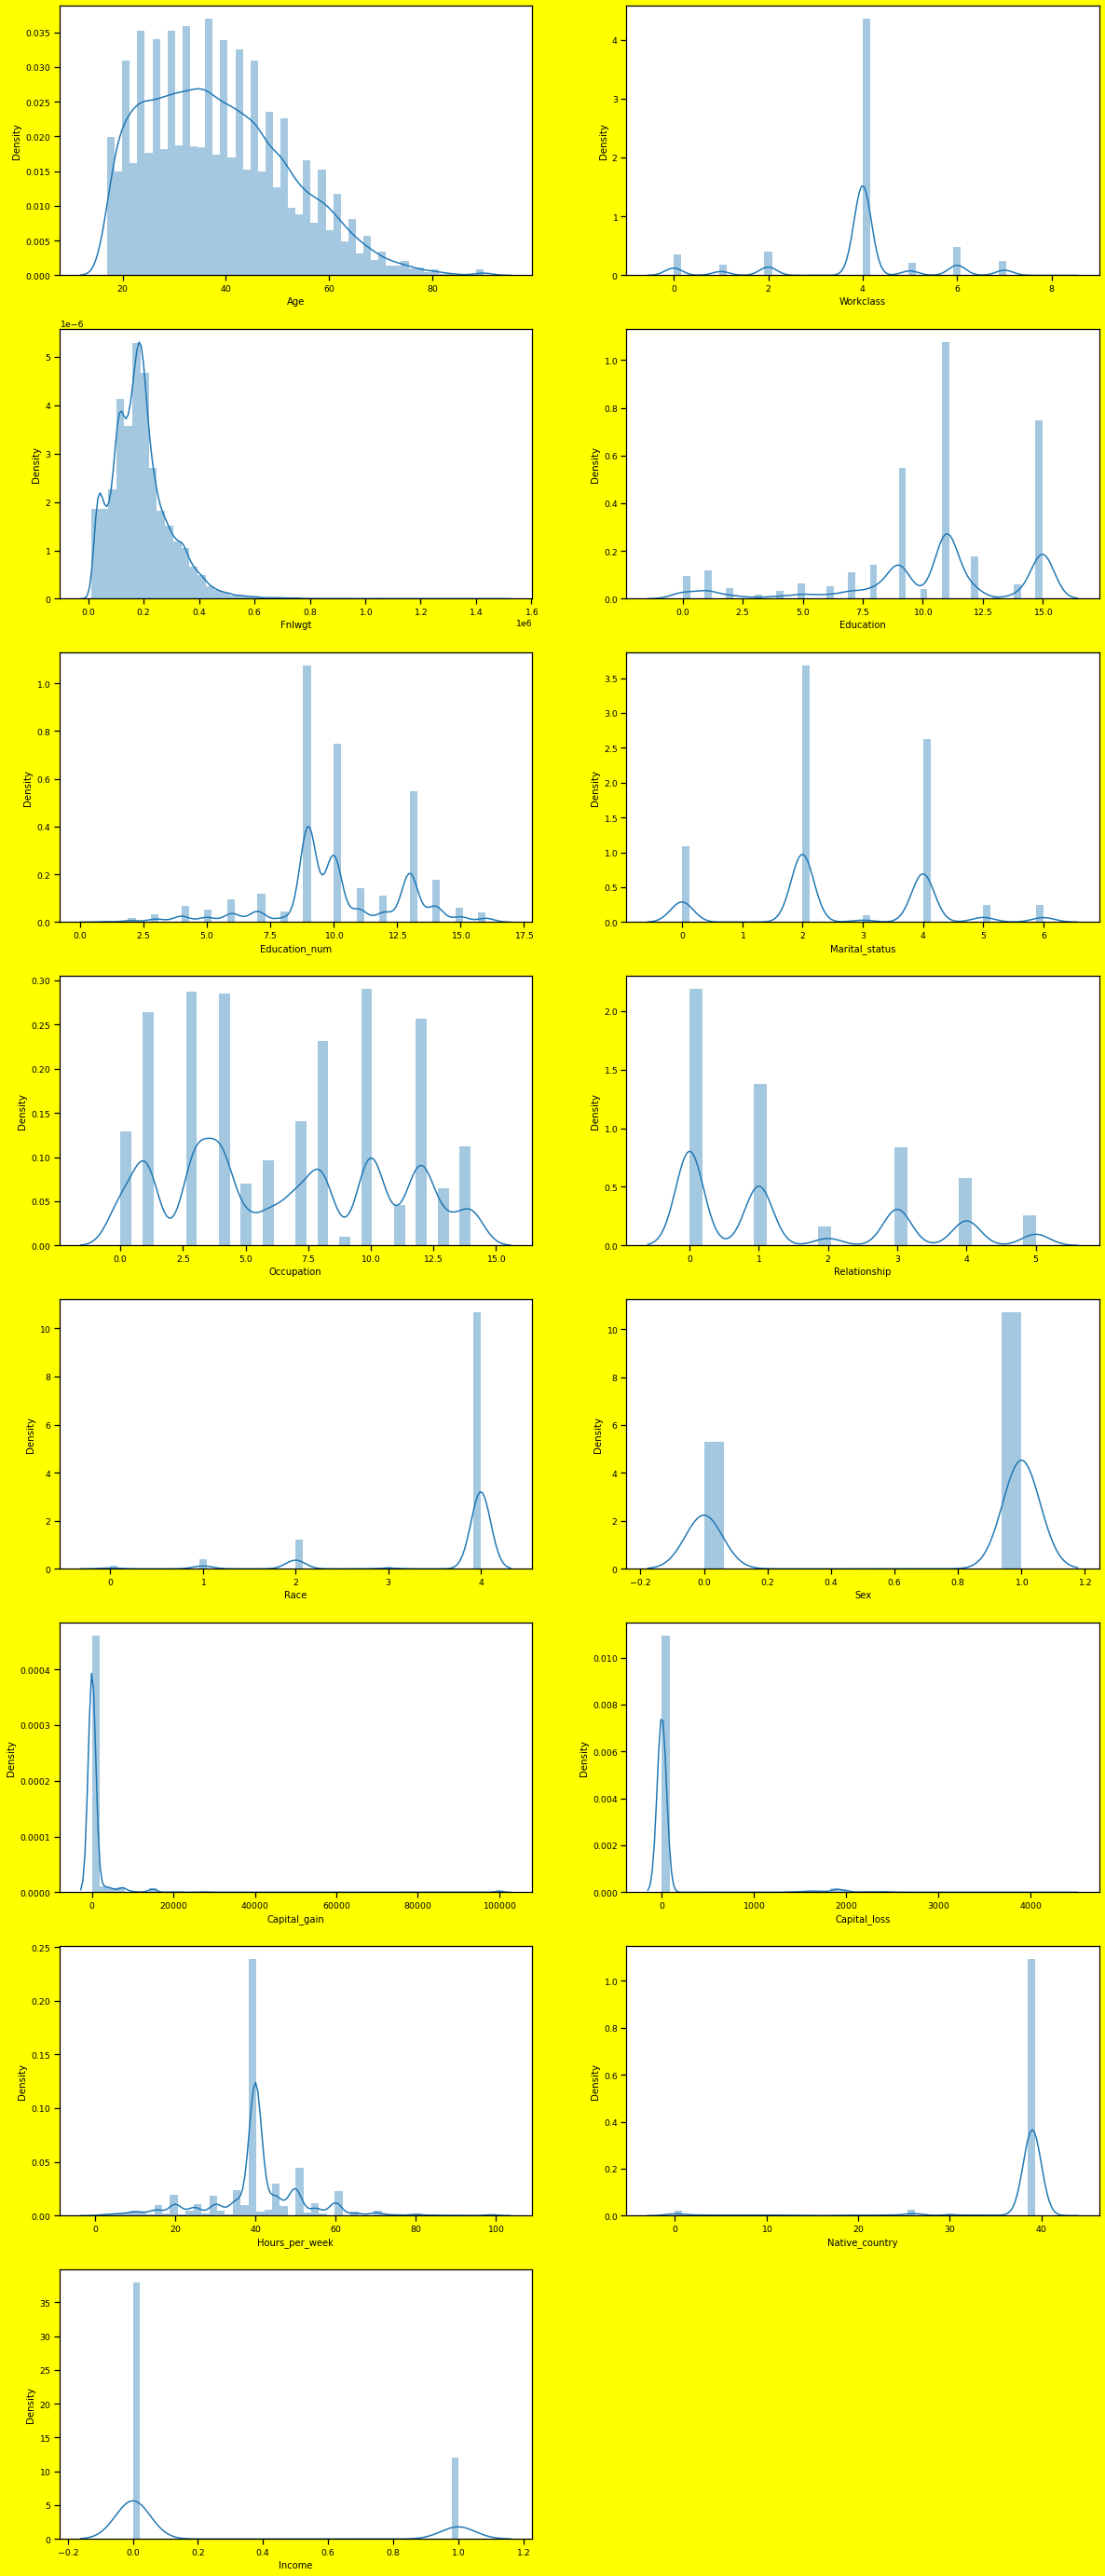

In [93]:
plt.figure(figsize=(20,50),facecolor="yellow")
plotnumber=1
for column in data:
    if plotnumber<=16:
        ax=plt.subplot(8,2,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

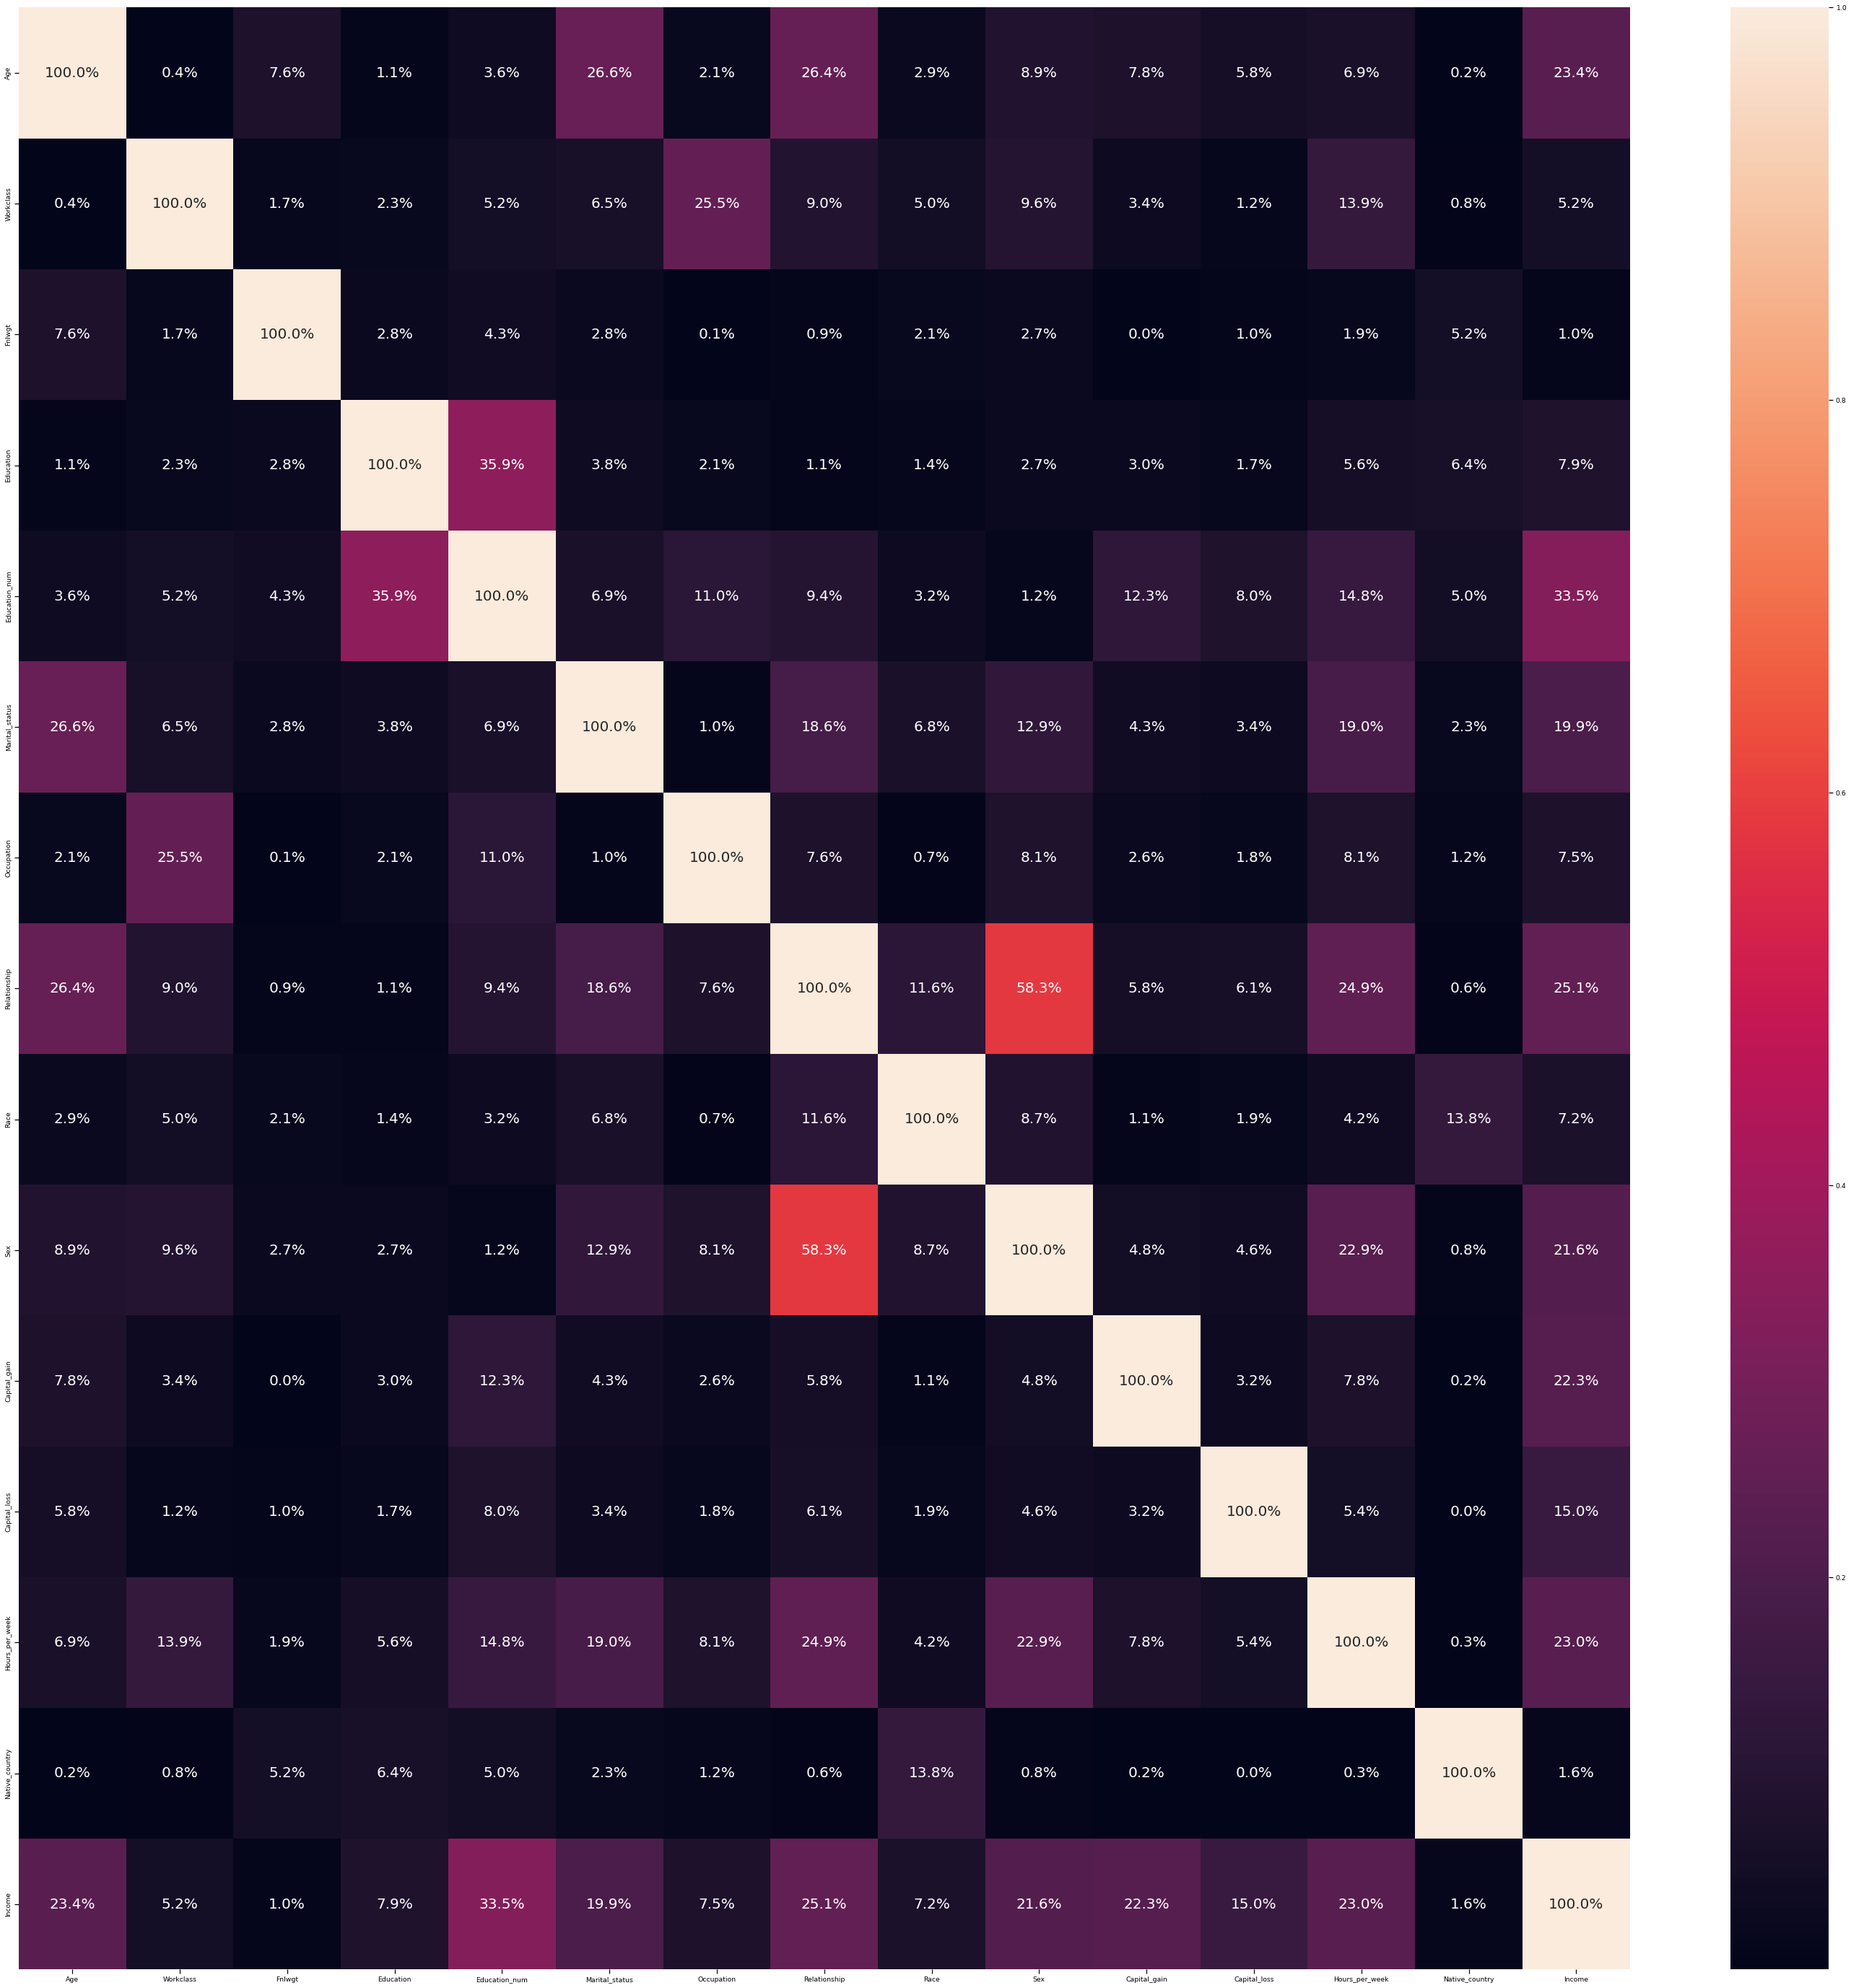

In [94]:
df_corr=data.corr().abs()
plt.figure(figsize=(50,50))
sns.heatmap(df_corr,annot=True, annot_kws={'size':20}, fmt='.1%')
plt.show()

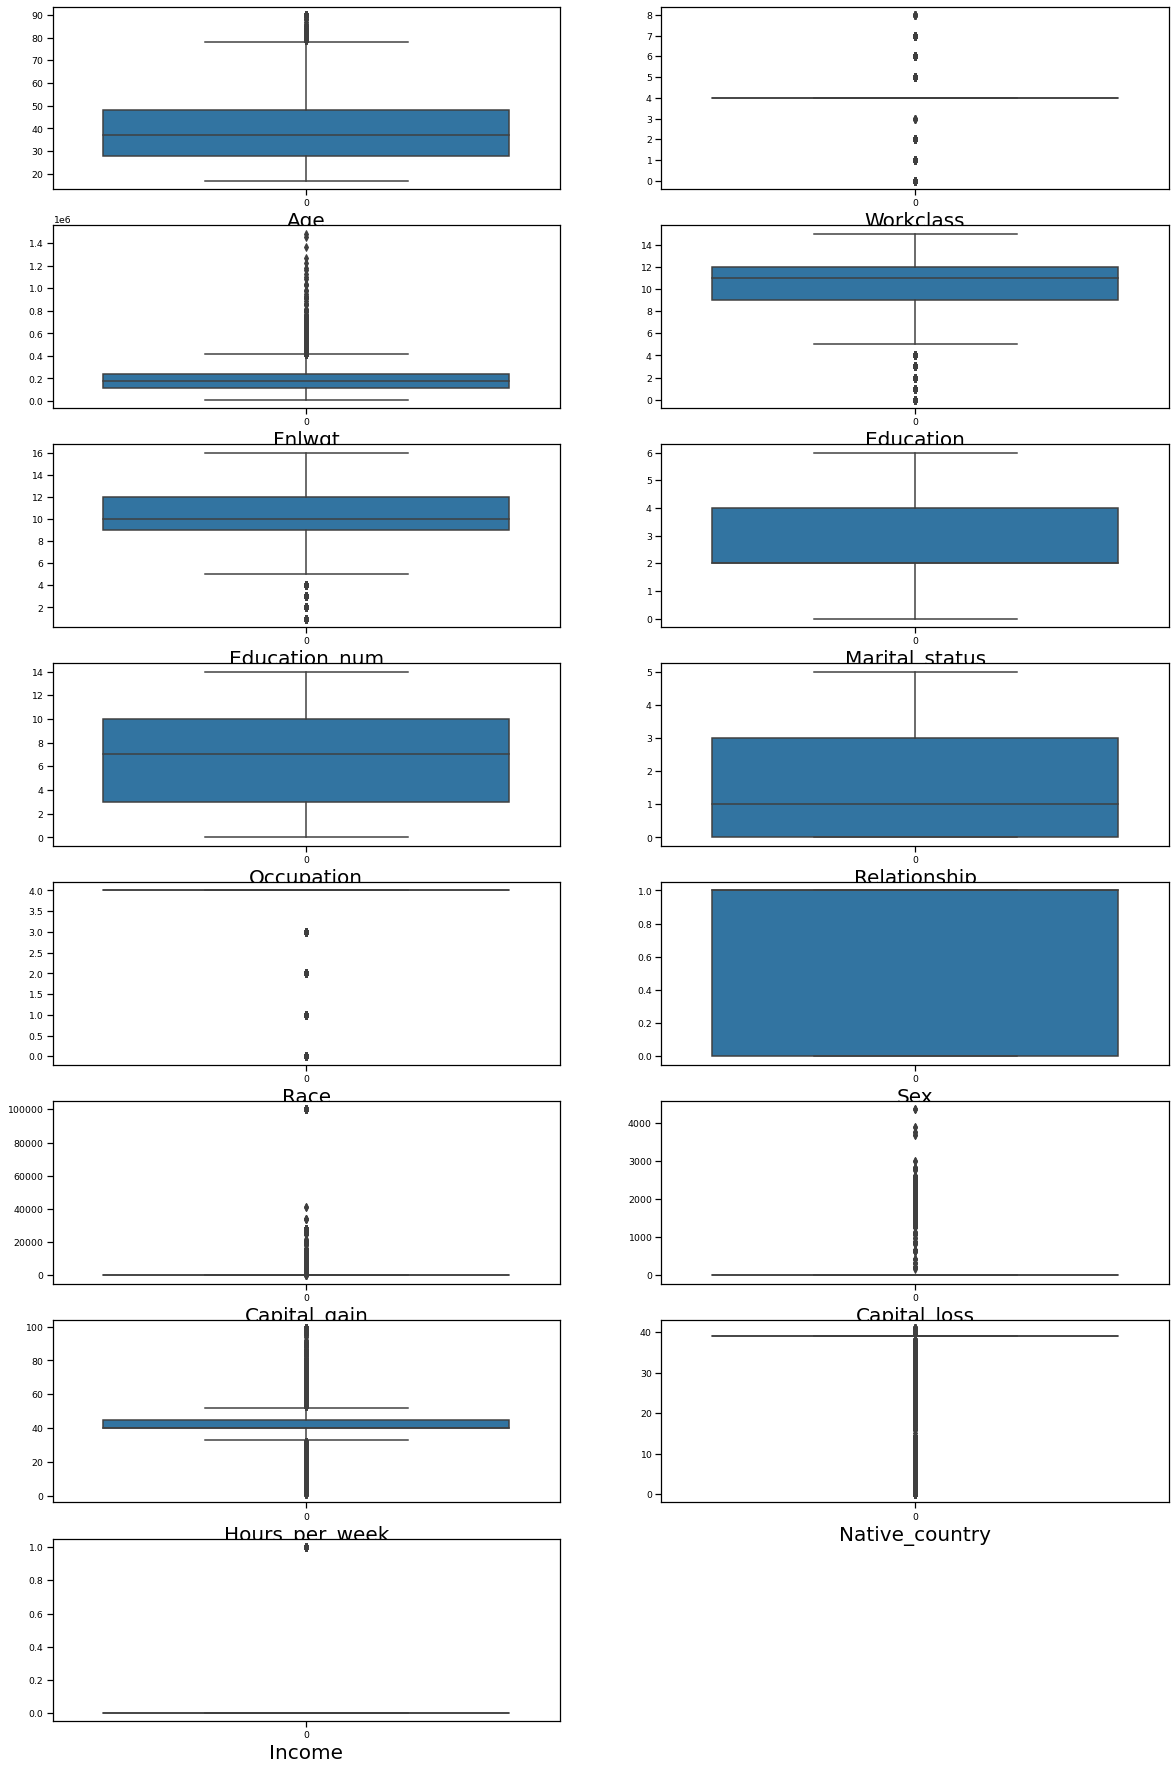

In [95]:
#Let's check for outliers
plt.figure(figsize=(20,100))
graph=1
for column in data:
    if plotnumber<=50:
        ax=plt.subplot(25,2,graph)
        sns.boxplot(data=data[column])
        plt.xlabel(column,fontsize=20)
    graph+=1
plt.show()

Outliers are present, so let's go ahead and treat them

In [96]:
from scipy.stats import zscore
z= np.abs(zscore(data))

In [97]:
threshold= 3 
print(np.where(z>3))

(array([    3,     9,    10, ..., 32508, 32526, 32528], dtype=int64), array([13, 12,  8, ...,  8,  8,  8], dtype=int64))


In [98]:
df=data[(z<3).all(axis=1)]
print(data.shape)
print(df.shape)

(32536, 15)
(27399, 15)


Outliers removed

let's proceed checking if our balanced or not

In [99]:
data['Income'].value_counts()

0    24697
1     7839
Name: Income, dtype: int64

This shows our data is imbalanced, so let's balance it

In [100]:
# Let us know split our data into Features & labels

x=data.drop('Income', axis=1)
y=data['Income']

In [101]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)

In [102]:

# Now let's split our data into Train_test_split

x_train, x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.25, random_state=44)

In [103]:
y_train.value_counts()

0    18485
1     5917
Name: Income, dtype: int64

In [104]:
sm=SMOTE()

In [105]:
ove_smp=SMOTE(0.75)

x_train_ns,y_train_ns = ove_smp.fit_resample(x_train,y_train)

In [106]:
y_train_ns.value_counts()

0    18485
1    13863
Name: Income, dtype: int64

Now our data seems to be in good shape

# Now, let's start model building

In [107]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [108]:
classifiers = [GaussianNB(), 
               SVC(kernel = 'rbf', probability = True), 
               DecisionTreeClassifier(random_state = 0), 
               RandomForestClassifier(n_estimators = 100, random_state = 0), 
               GradientBoostingClassifier(random_state = 0)]
classifier_names = ["Gaussian Naive Bayes", 
                    "Support Vector Classifier", 
                    "Decision Tree Classifier", 
                    "Random Forest Classifier", 
                    "Gradient Boosting Classifier"]
accuracies = []

In [109]:
for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(x_train_ns, y_train_ns)
    y_pred = classifier.predict(x_test)
    print("{}:".format(classifier_names[i]))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    accuracy = accuracy_score(y_test, y_pred)*100
    accuracies.append(accuracy)

Gaussian Naive Bayes:
F1 score: 0.54
Support Vector Classifier:
F1 score: 0.68
Decision Tree Classifier:
F1 score: 0.61
Random Forest Classifier:
F1 score: 0.67
Gradient Boosting Classifier:
F1 score: 0.70


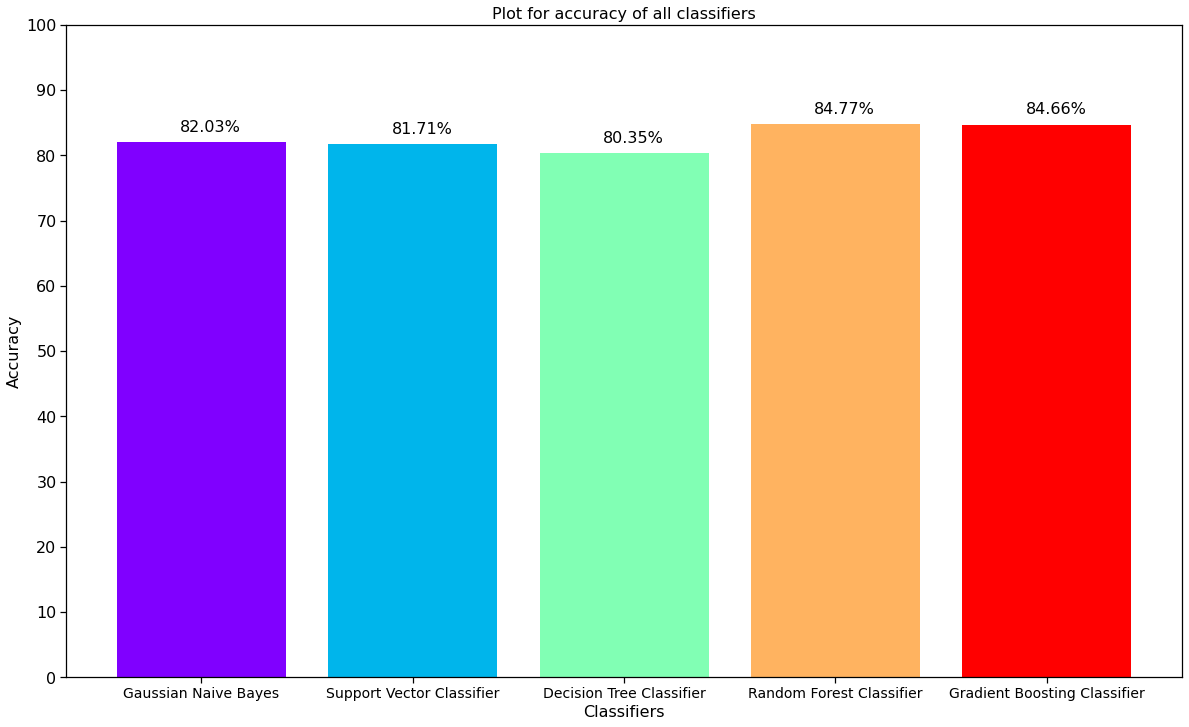

In [110]:
from matplotlib.cm import rainbow

plt.figure(figsize = (20, 12))
colors = rainbow(np.linspace(0, 1, len(classifiers)))
barplot = plt.bar(classifier_names, accuracies, color = colors)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize = 16)
plt.xticks(fontsize = 14)
plt.xlabel("Classifiers", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.title("Plot for accuracy of all classifiers", fontsize = 16)
for i, bar in enumerate(barplot):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, 
             bar.get_height()*1.02, 
             s = '{:.2f}%'.format(accuracies[i]), 
             fontsize = 16)

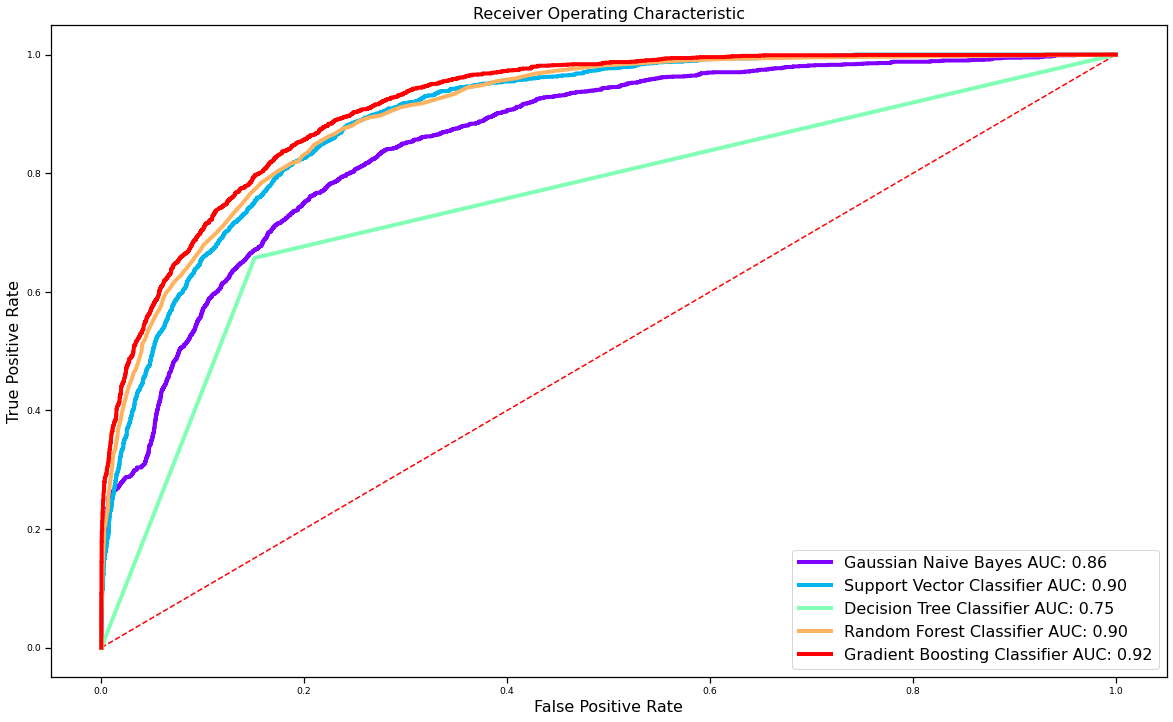

In [111]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

for i in range(len(classifiers)):
    classifier = classifiers[i]
    probs = classifier.predict_proba(x_test)
    # Reading probability of second class
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    label = classifier_names[i] + ' AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = colors[i], label = label, linewidth = 4)
    
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [112]:
#Saving the best model for future predictions

filename='Census_Income_Project.pickle'
pickle.dump(GradientBoostingClassifier,open(filename,'wb'))